In [7]:
from typing import List, Callable, Tuple, Dict
import numpy as np
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from itertools import combinations

from tqdm import tqdm
import pickle
import os

In [8]:
#-----------METHODE UTILES--------------

def haversine_distance(coord1, coord2):
    """Calcule la distance entre deux points (lat, lon) en mètres en utilisant la formule de Haversine."""
    # Rayon de la Terre en mètres
    R = 6371000
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


In [62]:
class Trajectoire:

    """
    Classe représentant une trajectoire d'avion avec gestion de la vitesse, des positions,
    et détection de conflits. Cette classe contient les méthodes principales suivantes :

    Initialisation:
    ---------------
    def __init__(self, id_avion: str, positions: List[Tuple[float, float, float]], vitesses: List[float], temps: List[float])
        Initialise les attributs de la trajectoire pour l'avion, incluant son identifiant, les positions, 
        les vitesses, les temps associés et une liste de conflits détectés.

    Modificateurs:
    --------------
    def ajuster_vitesse(self, t_changement: float, nouvelle_vitesse: float, limite_relative: float = 0.1)
        Ajuste les composantes horizontales de la vitesse (x et y) pour atteindre la norme cible à un instant 
        `t_changement` donné, en respectant une limite relative de variation de vitesse. Met à jour les positions 
        futures pour tenir compte de ce changement.
        

    Amélioration de trajectoire:
    ----------------------------
    def discretisation(self, dt: float) -> 'Trajectoire'
        Crée une nouvelle trajectoire en interpolant les positions et vitesses selon un intervalle de temps `dt`. 
        Retourne une nouvelle instance de Trajectoire avec les positions, vitesses et temps recalculés.

    Accesseurs:
    -----------
    def get_vitesse(self, temps_cible: float)
        Calcule et retourne la vitesse interpolée (vx, vy, vz) de l'avion pour un temps spécifique `temps_cible`,
        en utilisant la vitesse moyenne entre deux points temporels adjacents.

    def get_position(self, temps_cible: float)
        Calcule et retourne la position interpolée (lat, lon, alt) de l'avion pour un temps donné `temps_cible`,
        en utilisant une interpolation linéaire entre deux positions temporelles adjacentes.

    Utilitaires:
    ------------
    def indice_dernier_temps(self, temps_cible: float) -> int
        Renvoie l'indice du dernier instant dans `self.temps` qui est inférieur ou égal à `temps_cible`.
        Renvoie -1 si aucun temps ne correspond.

    Détection de conflit:
    ---------------------
    def se_croise_avec(self, autre_trajectoire: 'Trajectoire', distance_min_laterale: float, distance_min_verticale: float) -> bool
        Vérifie si cette trajectoire croise `autre_trajectoire` indépendamment du temps. Si un croisement est trouvé, 
        renvoie un tuple avec les ID des deux avions et la différence de temps absolue entre leurs positions au point de croisement.

    def detecter_conflits_temporels(self, autre_trajectoire: 'Trajectoire', distance_min_laterale: float, distance_min_verticale: float, delta_temps_max: float) -> list
        Détecte les conflits entre cette trajectoire et une autre `autre_trajectoire` en prenant en compte le temps.
        Retourne une liste de conflits sous forme de tuples (id_avion1, id_avion2, delta_temps, position_conflit), 
        avec le point de conflit étant défini si les distances et la différence de temps sont en dessous des seuils.

    def indices_temps_communs(self, autre_trajectoire: 'Trajectoire') -> Tuple[List[int], List[int]]
        Identifie les instants temporels communs entre deux trajectoires et renvoie deux listes d’indices, 
        une pour chaque trajectoire, indiquant ces instants communs.
    """





class Trajectoire:

    #-----------------------------------------
    #-----------------------------------------

    def __init__(self, id_avion: str, positions: List[Tuple[float, float, float]], vitesses: List[float], temps: List[float]):
        self.id_avion = id_avion
        self.positions = positions  # [(lat, lon, alt), ...]
        self.vitesses = vitesses    # [speed, ...]
        self.temps = temps          # [timestamp, ...]
        self.conflits = []          # Conflits détectés sur cette trajectoire


    #-----------------------------------------
    #-----------------------------------------

    def ajuster_vitesse(self, t_changement: float, norme_vitesse_cible: float, limite_relative: float = 0.1):

        # Trouver l'index du temps le plus proche de `t_changement`
        index_changement = min(range(len(self.temps)), key=lambda i: abs(self.temps[i] - t_changement))

        # Extraire les composantes de la vitesse actuelle
        vx, vy, vz = self.vitesses[index_changement]
        norme_vitesse_actuelle = np.sqrt(vx**2 + vy**2) 

        # Calculer la différence de norme (dv) et vérifier la limite de variation
        dv = norme_vitesse_cible - norme_vitesse_actuelle
        limite_relative_dv = limite_relative * abs(norme_vitesse_actuelle)
        if np.linalg.norm(dv) > limite_relative_dv:
            print(f"Changement de vitesse rejeté : dv ({dv} m/s) dépasse la limite relative de {limite_relative_dv} m/s.")
            return

        # Ajuster vx et vy pour atteindre la norme cible sans modifier la direction
        if norme_vitesse_actuelle > 0:
            facteur = norme_vitesse_cible / norme_vitesse_actuelle
            vx, vy = vx * facteur, vy * facteur

        # Appliquer le changement de vitesse en maintenant vz inchangé
        self.vitesses[index_changement] = (vx, vy, vz)

        if index_changement < len(self.temps) - 1:
            delta_t_avance = (np.linalg.norm(dv) / norme_vitesse_actuelle) * (self.temps[index_changement + 1] - self.temps[index_changement])

            # Mettre à jour les positions futures
            for i in range(index_changement + 1, len(self.temps)):
                t_prime = self.temps[i] + delta_t_avance

                # Interpolation linéaire pour ajuster position(t + delta_t_avance)
                for j in range(1, len(self.temps)):
                    if self.temps[j-1] <= t_prime < self.temps[j]:
                        lat1, lon1, alt1 = self.positions[j-1]
                        lat2, lon2, alt2 = self.positions[j]
                        t1, t2 = self.temps[j-1], self.temps[j]

                        # Calculer les coordonnées interpolées
                        factor = (t_prime - t1) / (t2 - t1)
                        lat_prime = lat1 + (lat2 - lat1) * factor
                        lon_prime = lon1 + (lon2 - lon1) * factor
                        alt_prime = alt1 + (alt2 - alt1) * factor

                        # Mettre à jour la position ajustée
                        self.positions[i] = (lat_prime, lon_prime, alt_prime)
                        break


    #-----------------------------------------
    #-----------------------------------------


    def discretisation(self, dt: float) -> 'Trajectoire':
        t0_prime = int(self.temps[0] // dt) * dt
        tN_prime = int(self.temps[-1] // dt) * dt
        temps_nouveau = [t for t in range(int(t0_prime), int(tN_prime) + int(dt), int(dt))]

        positions_nouvelles = []
        vitesses_nouvelles = []

        for t_prime in temps_nouveau:
            for j in range(1, len(self.temps)):
                if self.temps[j-1] <= t_prime < self.temps[j]:
                    lat1, lon1, alt1 = self.positions[j-1]
                    lat2, lon2, alt2 = self.positions[j]
                    t1, t2 = self.temps[j-1], self.temps[j]

                    # Interpolation linéaire pour chaque coordonnée
                    lat_prime = lat1 + (lat2 - lat1) * (t_prime - t1) / (t2 - t1)
                    lon_prime = lon1 + (lon2 - lon1) * (t_prime - t1) / (t2 - t1)
                    alt_prime = alt1 + (alt2 - alt1) * (t_prime - t1) / (t2 - t1)
                    positions_nouvelles.append((lat_prime, lon_prime, alt_prime))

                    # Calculer la vitesse vectorielle si ce n'est pas le premier point
                    if len(positions_nouvelles) > 1:
                        lat_prev, lon_prev, alt_prev = positions_nouvelles[-2]
                        vx = (lat_prime - lat_prev) / dt
                        vy = (lon_prime - lon_prev) / dt
                        vz = (alt_prime - alt_prev) / dt
                        vitesses_nouvelles.append((vx, vy, vz))
                    else:
                        vitesses_nouvelles.append((0, 0, 0))
                    break

        return Trajectoire(self.id_avion, positions_nouvelles, vitesses_nouvelles, temps_nouveau[:len(temps_nouveau)-2])


    #-----------------------------------------
    #-----------------------------------------


    def get_vitesse(self, temps_cible: float):
        i = self.indice_dernier_temps(temps_cible)
        if i is None or i >= len(self.temps) - 1:
            return None

        t1, t2 = self.temps[i], self.temps[i + 1]
        vit1 = np.array(self.vitesses[i])
        vit2 = np.array(self.vitesses[i + 1])

        # Interpolation linéaire pour la vitesse
        fraction = (temps_cible - t1) / (t2 - t1)
        vitesse_interpolee = vit1 + fraction * (vit2 - vit1)
        
        return tuple(vitesse_interpolee)

    def get_position(self, temps_cible: float):
        i = self.indice_dernier_temps(temps_cible)
        if i is None or i >= len(self.temps) - 1:
            return None

        t1, t2 = self.temps[i], self.temps[i + 1]
        pos1 = np.array(self.positions[i])
        pos2 = np.array(self.positions[i + 1])

        # Interpolation linéaire pour la position
        fraction = (temps_cible - t1) / (t2 - t1)
        position_interpolee = pos1 + fraction * (pos2 - pos1)
        
        return tuple(position_interpolee)
    
    def indice_dernier_temps(self, temps_cible: float) -> int:
        for i in reversed(range(len(self.temps))):
            if self.temps[i] <= temps_cible:
                return i
        return -1


    #-----------------------------------------
    #-----------------------------------------
                    

    def se_croise_avec(self, autre_trajectoire: 'Trajectoire', distance_min_laterale: float, distance_min_verticale: float) :

        positions1 = np.array(self.positions)
        positions2 = np.array(autre_trajectoire.positions)
        temps1 = np.array(self.temps)
        temps2 = np.array(autre_trajectoire.temps)

        # Parcourt chaque position de la première trajectoire
        for i, pos1 in enumerate(positions1):
            lat1, lon1, alt1 = pos1[:3]
            
            # Calcul de la distance latérale entre la position courante de trajectoire 1 et toutes les positions de trajectoire 2
            dist_laterale = np.sqrt((positions2[:, 0] - lat1) ** 2 + (positions2[:, 1] - lon1) ** 2)
            
            # Trouver les indices de trajectoire 2 où la distance latérale est inférieure à la distance minimale spécifiée
            indices_proches = np.where(dist_laterale < distance_min_laterale)[0]
            
            # Vérification des conflits pour les positions rapprochées
            for idx in indices_proches:
                alt2 = positions2[idx - 1, 2]
                dist_verticale = abs(alt1 - alt2)
                
                # Si les distances latérale et verticale sont sous les seuils spécifiés, un conflit est trouvé
                if dist_verticale < distance_min_verticale:
                    # Calcul de la différence de temps absolue entre les deux positions au point de conflit
                    delta_temps = abs(temps1[i] - temps2[idx - 1])
                    
                    # Retourne True avec les ID des avions et la différence de temps
                    return True, (self.id_avion, autre_trajectoire.id_avion, delta_temps)

        # Si aucun croisement n'est trouvé, retourne False avec None
        return False, None
    

    def detecter_conflits_temporels(self, autre_trajectoire: 'Trajectoire', distance_min_laterale: float, distance_min_verticale: float, delta_temps_max: float) -> list:

        positions1 = np.array(self.positions[:len(self.temps)])
        positions2 = np.array(autre_trajectoire.positions[:len(autre_trajectoire.temps)])
        temps1 = np.array(self.temps)
        temps2 = np.array(autre_trajectoire.temps)

        conflits = []

        # Parcourt chaque position de la première trajectoire
        for i, pos1 in enumerate(positions1):
            lat1, lon1, alt1 = pos1[:3]
            temps_avion1 = temps1[i]

            # Calcul de la distance latérale entre la position courante de trajectoire 1 et toutes les positions de trajectoire 2
            for j, pos2 in enumerate(positions2):
                lat2, lon2, alt2 = pos2[:3]
                temps_avion2 = temps2[j]

                # Utiliser la formule de Haversine pour calculer la distance latérale
                dist_laterale = haversine_distance((lat1, lon1), (lat2, lon2))
                dist_verticale = abs(alt1 - alt2)
                delta_temps = abs(temps_avion1 - temps_avion2)

                # Vérifier les distances latérale, verticale, et la différence de temps
                if dist_laterale < distance_min_laterale and dist_verticale < distance_min_verticale and delta_temps <= delta_temps_max:
                    # Position du point de conflit (moyenne des positions des deux avions au point de conflit)
                    position_conflit = ((lat1 + lat2) / 2, (lon1 + lon2) / 2, (alt1 + alt2) / 2)
                    
                    # Ajouter le conflit à la liste
                    conflits.append((self.id_avion, autre_trajectoire.id_avion, delta_temps, position_conflit))

        return conflits


    #-----------------------------------------
    #-----------------------------------------

    def indices_temps_communs(self, autre_trajectoire: 'Trajectoire') -> Tuple[List[int], List[int]]:
        indices_self = []
        indices_autre = []
        i, j = 0, 0
        while i < len(self.temps) and j < len(autre_trajectoire.temps):
            if self.temps[i] == autre_trajectoire.temps[j]:
                indices_self.append(i)
                indices_autre.append(j)
                i += 1
                j += 1
            elif self.temps[i] < autre_trajectoire.temps[j]:
                i += 1
            else:
                j += 1

        return indices_self, indices_autre
    

    def lisser_vitesses(self, fenetre: int = 5):
        """
        Lisse les vitesses horizontales (x et y) avec une fenêtre coulissante de taille spécifiée
        en gardant la composante verticale (z) intacte. Utilise `ajuster_vitesse` pour chaque ajustement.
        """
        if fenetre < 1 or fenetre % 2 == 0:
            raise ValueError("La taille de la fenêtre doit être un entier impair supérieur à 1.")
        
        # Extraire les composantes horizontales (x et y) et verticale (z) des vitesses
        vitesses_x = np.array([v[0] for v in self.vitesses])
        vitesses_y = np.array([v[1] for v in self.vitesses])
        vitesses_z = np.array([v[2] for v in self.vitesses])  # Garder la composante z d'origine

        # Appliquer un filtre de moyenne glissante aux composantes x et y
        vitesses_x_lissees = np.convolve(vitesses_x, np.ones(fenetre) / fenetre, mode='same')
        vitesses_y_lissees = np.convolve(vitesses_y, np.ones(fenetre) / fenetre, mode='same')

        # Ajuster la moyenne des composantes x et y lissées pour qu'elles soient proches de l'originale
        facteur_x = np.mean(vitesses_x) / np.mean(vitesses_x_lissees)
        facteur_y = np.mean(vitesses_y) / np.mean(vitesses_y_lissees)
        vitesses_x_lissees *= facteur_x
        vitesses_y_lissees *= facteur_y

        # Ajuster les vitesses en utilisant `ajuster_vitesse`
        for i in range(1,min(len(self.temps),len(self.vitesses))):
            nouvelle_vitesse = (vitesses_x_lissees[i], vitesses_y_lissees[i], vitesses_z[i])
            self.ajuster_vitesse(self.temps[i], nouvelle_vitesse,100000000000)




In [73]:
class Simulation:


    """
    Classe pour simuler des trajectoires d'avions et détecter des conflits.

    Initialisation :
    ----------------
    def __init__(self, username, password):
        Initialise une simulation avec des paramètres facultatifs pour les informations d'authentification et les données de simulation.
    
    def __init__(self, username=None, password=None, trajectoires=None, traj_haute_fidelite=None, zones_de_conflit=None, conflits=None, parametres_meteo=None)
        Utilisé pour charge une simulation à partir de la methode de classe charger_simulation

    Création de trajectoires :
    --------------------------
    def create_trajectoires(self, latitude_min, latitude_max, longitude_min, longitude_max, duration_minutes=24, max_trajectories=10)
        Récupère et crée des trajectoires d'avions en utilisant l'API OpenSky Network dans une région géographique spécifiée.

    Discrétisation des trajectoires :
    ---------------------------------
    def generate_traj_bf(self)
        Génère des trajectoires basse fidélité en discrétisant les données de trajectoires existantes avec un delta de temps spécifique.

    def generate_traj_hf(self)
        Génère des trajectoires haute fidélité en discrétisant les données de trajectoires existantes avec un delta de temps plus précis.

    Calcul des distances :
    ----------------------
    def matrice_distances(self, type_traj="traj_hf") -> np.ndarray
        Renvoie une matrice de distance 3D (avion, avion, temps//dt) où chaque point (i, j, t)
        contient un tuple (distance_horizontale en NM, distance_verticale en ft) entre l'avion i et j
        au temps discretisé t.

    Calcul du delta de temps :
    --------------------------
    def delta_haute_fidelite(self) -> float
        Calcule et renvoie le delta de temps moyen pour les trajectoires, ajusté pour une discrétisation haute fidélité.

    def delta_basse_fidelite(self) -> float
        Calcule et renvoie le delta de temps moyen pour les trajectoires, ajusté pour une discrétisation basse fidélité.

    Affichage :
    -----------
    def display_trajectoires(self)
        Affiche les trajectoires sur une carte avec un gradient de couleur représentant le temps.

    def display_traj_haute_fidelite(self)
        Affiche les trajectoires haute fidélité (interpolées) avec un gradient de couleur en fonction du temps.

    def display_traj_basse_fidelite(self)
        Affiche les trajectoires basse fidélité avec un gradient de couleur en fonction du temps.

    def display_velocity_profiles(self)
        Affiche les profils de vitesse de chaque trajectoire en fonction du temps.

    def display_hf_velocity_profiles(self)
        Affiche les profils de vitesse des trajectoires haute fidélité en fonction du temps.

    def display_bf_velocity_profiles(self)
        Affiche les profils de vitesse des trajectoires basse fidélité en fonction du temps.

    def display_altitude_profiles(self)
        Affiche les profils d'altitude de chaque trajectoire en fonction du temps.

    def display_hf_altitude_profiles(self)
        Affiche les profils d'altitude des trajectoires haute fidélité en fonction du temps.

    def display_bf_altitude_profiles(self)
        Affiche les profils d'altitude des trajectoires basse fidélité en fonction du temps.

    Sauvegarde et chargement :
    --------------------------
    def sauvegarder_simulation(self, chemin_fichier: str)
        Sauvegarde l'état actuel de la simulation dans un fichier .pkl.

    @classmethod
    def charger_simulation(cls, chemin_fichier: str) -> 'Simulation'
        Charge une simulation enregistrée depuis un fichier .pkl.

    Gestion et détection des conflits :
    -----------------------------------
    def trajectoires_se_croisent(self, distance_min_laterale: float, distance_min_verticale: float) -> bool
        Vérifie si des trajectoires se croisent en utilisant une distance minimale latérale (2D) et verticale.

    def compter_conflits(self) -> int
        Compte et retourne le nombre total de conflits détectés dans la simulation.

    def detecter_conflits(self, matrice_distances: np.ndarray, seuil_distance_horizontale: float, seuil_distance_verticale: float) -> list
        Détecte les conflits de distance entre trajectoires en analysant la matrice de distances 3D.
        Renvoie une liste de conflits détectés sous la forme de tuples (avion_i, avion_j, temps, distance_horizontale, distance_verticale).

    """


    def __init__(self, username, password):
        self.username = username
        self.password = password
        self.trajectoires = []  # Liste des trajectoires en simulation
        self.traj_haute_fidelite = []
        self.traj_basse_fidelite = []
        self.zones_de_conflit = []  # Liste des zones de conflit
        self.conflits = []  # Conflits détectés
        self.parametres_meteo = {}  # Dictionnaire de paramètres météorologiques

    def __init__(self, username=None, password=None, trajectoires=None, traj_basse_fidelite = None ,traj_haute_fidelite=None, zones_de_conflit=None, conflits=None, parametres_meteo=None):
        self.username = username
        self.password = password
        self.trajectoires = trajectoires if trajectoires is not None else []
        self.traj_haute_fidelite = traj_haute_fidelite if traj_haute_fidelite is not None else []
        self.traj_basse_fidelite = traj_basse_fidelite if traj_basse_fidelite is not None else []
        self.zones_de_conflit = zones_de_conflit if zones_de_conflit is not None else []
        self.conflits = conflits if conflits is not None else []
        self.parametres_meteo = parametres_meteo if parametres_meteo is not None else {}


    # --------------récuperation des trajectoire OSN--------------------
        
    def create_trajectoires(self, latitude_min, latitude_max, longitude_min, longitude_max, duration_minutes=24, max_trajectories=10):

        # URL pour obtenir les avions dans la région
        states_url = "https://opensky-network.org/api/states/all"
        
        # Définir la période (dernières 'duration_minutes' minutes)
        end_time = datetime.utcnow()
        start_time = end_time - timedelta(minutes=duration_minutes)
        start_timestamp = int(start_time.timestamp())
        
        # Paramètres pour la requête
        params = {
            "lamin": latitude_min,
            "lamax": latitude_max,
            "lomin": longitude_min,
            "lomax": longitude_max,
            }

        # Récupérer les avions dans la région
        response = requests.get(states_url, params=params, auth=(self.username, self.password))

        if response.status_code == 200:
            data = response.json()
            if 'states' in data:
                trajectories_plotted = 0
                for state in data['states']:
                    if trajectories_plotted >= max_trajectories:
                        break
                    
                    icao24 = state[0]
                    callsign = state[1].strip()

                    # Récupérer les trajectoires pour chaque avion
                    track_url = f"https://opensky-network.org/api/tracks/all?icao24={icao24}&time={start_timestamp}"
                    track_response = requests.get(track_url, auth=(self.username, self.password))

                    if track_response.status_code == 200:
                        
                        track_data = track_response.json()

                        positions = []
                        vitesses = []
                        temps = []

                        for point in track_data.get('path', []):  # Utiliser .get('path', []) pour éviter l'erreur si 'path' est manquant
                            latitude, longitude, altitude = point[1], point[2], point[3]
                            timestamp = point[0]
                            
                            positions.append((latitude, longitude, altitude))
                            temps.append(timestamp)
                            
                            # Calculer la vitesse entre points consécutifs
                            if len(positions) > 1:
                                prev_position = np.array(positions[-2])
                                current_position = np.array(positions[-1])
                                distance = np.linalg.norm(current_position[:2] - prev_position[:2])
                                time_diff = temps[-1] - temps[-2]
                                vitesse = distance / time_diff if time_diff > 0 else 0
                                vitesses.append(vitesse)
                            else:
                                vitesses.append(0)

                        # Créer et stocker l'objet Trajectoire même si elle est incomplète
                        trajectoire = Trajectoire(id_avion=callsign, positions=positions, vitesses=vitesses, temps=temps)
                        self.trajectoires.append(trajectoire)
                        trajectories_plotted += 1
                        
        else:
            print("Failed to retrieve data from states_url")
            print("Erreur lors de la récupération des états des avions :", response.status_code)
            

    def generate_traj_bf(self):
        for trajectoire in self.trajectoires:
            self.traj_basse_fidelite.append(trajectoire.discretisation(self.delta_basse_fidelite()))

    def generate_traj_hf(self):
        for trajectoire in self.trajectoires:
            self.traj_haute_fidelite.append(trajectoire.discretisation(self.delta_haute_fidelite()))
    

    def matrice_distances(self, type_traj = "traj_hf") -> np.ndarray:

        if type_traj == "traj_hf":
            trajectoires = self.traj_haute_fidelite
        elif type_traj == "traj_bf":
            trajectoires = self.traj_basse_fidelite
        elif type_traj == "traj_bf":
            trajectoires = self.trajectoires
        else:
            print("Problème arg type_traj")

        n = len(trajectoires)
        
        # Discrétiser le temps pour toutes les trajectoires et déterminer le nombre de pas de temps
        max_temps = max([len(traj.temps) for traj in trajectoires])

        # Initialiser la matrice 3D pour stocker les distances en tuples
        matrice_distances = np.empty((n, n, max_temps), dtype=object)

        # Conversion mètre -> NM (nautical miles) et mètre -> ft (feet)
        METERS_TO_NM = 0.000539957
        METERS_TO_FT = 3.28084

        # Calcul des distances pour chaque paire de trajectoires et chaque intervalle de temps
        for i in range(n):
            for j in range(i + 1, n):
                traj1, traj2 = trajectoires[i], trajectoires[j]
                min_len = min(len(traj1.temps), len(traj2.temps))

                for t in range(min_len):
                    # Calcul de la distance horizontale avec Haversine
                    lat1, lon1, alt1 = traj1.positions[t]
                    lat2, lon2, alt2 = traj2.positions[t]
                    distance_horizontale = haversine_distance((lat1, lon1), (lat2, lon2)) * METERS_TO_NM  # En NM

                    # Calcul de la distance verticale en ft
                    distance_verticale = abs(alt1 - alt2) * METERS_TO_FT

                    # Stocker la distance en tuple (distance_horizontale, distance_verticale)
                    matrice_distances[i, j, t] = (distance_horizontale, distance_verticale)
                    matrice_distances[j, i, t] = (distance_horizontale, distance_verticale)  # Symétrie

        return matrice_distances


    # -----------Dt Discretisation haute et basse fidelité  ------------------

    def delta_haute_fidelite(self) -> float:

        deltas_moyens = []

        for trajectoire in self.trajectoires:
            if len(trajectoire.temps) > 1:
                deltas = np.diff(trajectoire.temps)
                delta_moyen = np.mean(deltas)
                deltas_moyens.append(delta_moyen)

        return np.mean(deltas_moyens)*1.2 if deltas_moyens else 0
    
    def delta_basse_fidelite(self) -> float:

        deltas_moyens = []
        for trajectoire in self.trajectoires:
            if len(trajectoire.temps) > 1:
                deltas = np.diff(trajectoire.temps)
                delta_moyen = np.mean(deltas) * 10
                deltas_moyens.append(delta_moyen)

        return np.mean(deltas_moyens) if deltas_moyens else 0
    


    #-----------DISPLAY-------------------


    def display_trajectoires(self):
        plt.figure(figsize=(10, 8))

        # Palette de couleurs
        cmap = plt.get_cmap("viridis")

        for trajectoire in self.trajectoires:
            latitudes = [pos[0] for pos in trajectoire.positions]
            longitudes = [pos[1] for pos in trajectoire.positions]
            temps = trajectoire.temps

            # Normaliser le temps pour qu'il corresponde à la gamme de couleurs
            norm = plt.Normalize(vmin=min(temps), vmax=max(temps))

            # Appliquer un dégradé de couleur en fonction du temps
            for i in range(len(longitudes) - 1):
                plt.plot(
                    [longitudes[i], longitudes[i + 1]], 
                    [latitudes[i], latitudes[i + 1]], 
                    color=cmap(norm(temps[i])), 
                    marker='o', 
                    linestyle='-')

        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Trajectoires d'avions avec un gradient de couleur en fonction du temps")
        
        # Ajouter une barre de couleur pour indiquer la correspondance avec le temps
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([min(temps), max(temps)])  # Définir explicitement la gamme des données
        plt.colorbar(sm, ax=plt.gca(), label="Temps (timestamp)")

        plt.show()

    # Méthode dupliqué pour les trajectoires extrapoler haute fidelité (on peut surement faire mieux)
    def display_traj_haute_fidelite(self):
        plt.figure(figsize=(10, 8))

        # Palette de couleurs
        cmap = plt.get_cmap("viridis")

        for trajectoire in self.traj_haute_fidelite:
            latitudes = [pos[0] for pos in trajectoire.positions]
            longitudes = [pos[1] for pos in trajectoire.positions]
            temps = trajectoire.temps

            # Normaliser le temps pour qu'il corresponde à la gamme de couleurs
            norm = plt.Normalize(vmin=min(temps), vmax=max(temps))

            # Appliquer un dégradé de couleur en fonction du temps
            for i in range(len(longitudes) - 1):
                plt.plot(
                    [longitudes[i], longitudes[i + 1]], 
                    [latitudes[i], latitudes[i + 1]], 
                    color=cmap(norm(temps[i])), 
                    marker='o', 
                    linestyle='-')

        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Trajectoires d'avions haute fidelité")
        
        # Ajouter une barre de couleur pour indiquer la correspondance avec le temps
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([min(temps), max(temps)])  # Définir explicitement la gamme des données pour ScalarMappable
        plt.colorbar(sm, ax=plt.gca(), label="Temps (timestamp)")

        plt.show()

    # Méthode dupliqué pour les trajectoires extrapoler basse fidelité (on peut surement faire mieux)
    def display_traj_basse_fidelite(self):
        plt.figure(figsize=(10, 8))

        # Palette de couleurs
        cmap = plt.get_cmap("viridis")

        for trajectoire in self.traj_basse_fidelite:
            latitudes = [pos[0] for pos in trajectoire.positions]
            longitudes = [pos[1] for pos in trajectoire.positions]
            temps = trajectoire.temps

            # Normaliser le temps pour qu'il corresponde à la gamme de couleurs
            norm = plt.Normalize(vmin=min(temps), vmax=max(temps))

            # Appliquer un dégradé de couleur en fonction du temps
            for i in range(len(longitudes) - 1):
                plt.plot(
                    [longitudes[i], longitudes[i + 1]], 
                    [latitudes[i], latitudes[i + 1]], 
                    color=cmap(norm(temps[i])), 
                    marker='o', 
                    linestyle='-')

        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Trajectoires d'avions basse fidelité")
        
        # Ajouter une barre de couleur pour indiquer la correspondance avec le temps
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([min(temps), max(temps)])  # Définir explicitement la gamme des données pour ScalarMappable
        plt.colorbar(sm, ax=plt.gca(), label="Temps (timestamp)")

        plt.show()

    def display_velocity_profiles(self):
        plt.figure(figsize=(12, 8))

        for trajectoire in self.trajectoires:
            # Tracer la vitesse en fonction du temps
            plt.plot(trajectoire.temps, trajectoire.vitesses, label=trajectoire.id_avion)
        
        plt.xlabel("Temps (s)")
        plt.ylabel("Vitesse (m/s)")
        plt.title("Profil de vitesse des trajectoires")
        plt.legend(title="ID de la trajectoire")
        plt.grid(True)
        plt.show()

    def display_hf_velocity_profiles(self):
        plt.figure(figsize=(12, 8))
        for index, trajectoire in enumerate(self.traj_haute_fidelite):
            # Tracer la vitesse en fonction du temps
            print(trajectoire.vitesses[index][0]**2 + trajectoire.vitesses[index][1]**2 + trajectoire.vitesses[index][2]**2)
            print(trajectoire.temps)
            plt.plot(trajectoire.temps, [np.sqrt(vitesse[0]**2 + vitesse[1] + vitesse[2]**2) for vitesse in trajectoire.vitesses[:len(trajectoire.temps)]], label=trajectoire.id_avion)
        
        plt.xlabel("Temps (s)")
        plt.ylabel("Vitesse (m/s)")
        plt.title("Profil de vitesse des trajectoires haute fidelité")
        plt.legend(title="ID de la trajectoire")
        plt.grid(True)
        plt.show()

    def display_bf_velocity_profiles(self):
        plt.figure(figsize=(12, 8))

        for trajectoire in self.traj_basse_fidelite:
            # Tracer la vitesse en fonction du temps
            plt.plot(trajectoire.temps, [np.linalg.norm(vitesse) for vitesse in trajectoire.vitesses[:len(trajectoire.temps)]], label=trajectoire.id_avion)
        
        plt.xlabel("Temps (s)")
        plt.ylabel("Vitesse (m/s)")
        plt.title("Profil de vitesse des trajectoires basse fidelité")
        plt.legend(title="ID de la trajectoire")
        plt.grid(True)
        plt.show()


    def display_altitude_profiles(self):
        plt.figure(figsize=(12, 8))

        for trajectoire in self.trajectoires:
            # Récupérer les altitudes et tracer en fonction du temps
            altitudes = [pos[2] for pos in trajectoire.positions]
            plt.plot(trajectoire.temps, altitudes[:len(trajectoire.temps)], label=trajectoire.id_avion)
        
        plt.xlabel("Temps (s)")
        plt.ylabel("Altitude (m)")
        plt.title("Profil d'altitude des trajectoires")
        plt.legend(title="ID de la trajectoire")
        plt.grid(True)
        plt.show()

    def display_hf_altitude_profiles(self):
        plt.figure(figsize=(12, 8))

        for trajectoire in self.traj_haute_fidelite:
            # Récupérer les altitudes et tracer en fonction du temps
            altitudes = [pos[2] for pos in trajectoire.positions]
            plt.plot(trajectoire.temps, altitudes[:len(trajectoire.temps)], label=trajectoire.id_avion)
        
        plt.xlabel("Temps (s)")
        plt.ylabel("Altitude (m)")
        plt.title("Profil d'altitude des trajectoires haute fidelité")
        plt.legend(title="ID de la trajectoire")
        plt.grid(True)
        plt.show()

    def display_bf_altitude_profiles(self):
        plt.figure(figsize=(12, 8))

        for trajectoire in self.traj_basse_fidelite:
            # Récupérer les altitudes et tracer en fonction du temps
            altitudes = [pos[2] for pos in trajectoire.positions]
            plt.plot(trajectoire.temps, altitudes[:len(trajectoire.temps)], label=trajectoire.id_avion)
        
        plt.xlabel("Temps (s)")
        plt.ylabel("Altitude (m)")
        plt.title("Profil d'altitude des trajectoires basse fidelité")
        plt.legend(title="ID de la trajectoire")
        plt.grid(True)
        plt.show()

#--------------SAUVEGARDE DES TRAJECTOIRES ------------------


    def sauvegarder_simulation(self, chemin_fichier: str):
        try:
            with open(chemin_fichier, 'wb') as f:
                # Sauvegarder l'état complet de la simulation
                pickle.dump({
                    'username': self.username,
                    'password': self.password,
                    'trajectoires': self.trajectoires,
                    'traj_haute_fidelite': self.traj_haute_fidelite,
                    'traj_basse_fidelite': self.traj_basse_fidelite,
                    'zones_de_conflit': self.zones_de_conflit,
                    'conflits': self.conflits,
                    'parametres_meteo': self.parametres_meteo
                }, f)
            print(f"Simulation sauvegardée dans {chemin_fichier}.")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde de la simulation : {e}")


    @classmethod
    def charger_simulation(cls, chemin_fichier: str) -> 'Simulation':
        try:
            with open(chemin_fichier, 'rb') as f:
                data = pickle.load(f)
            
            # Créer une nouvelle instance de Simulation avec les données chargées
            simulation = cls(
                username=data.get('username'),
                password=data.get('password'),
                trajectoires=data.get('trajectoires', []),
                traj_haute_fidelite=data.get('traj_haute_fidelite', []),
                traj_basse_fidelite=data.get('traj_basse_fidelite', []),
                zones_de_conflit=data.get('zones_de_conflit', []),
                conflits=data.get('conflits', []),
                parametres_meteo=data.get('parametres_meteo', {})
            )
            print(f"Simulation chargée depuis {chemin_fichier}.")
            return simulation

        except Exception as e:
            print(f"Erreur lors du chargement de la simulation : {e}")
            return None



#-----------CONFLITS ------------------
    
    def trajectoires_se_croisent(self, distance_min_laterale: float, distance_min_verticale: float) -> bool:

        # Parcourt chaque paire unique de trajectoires pour vérifier les croisements
        # Calcul du nombre de combinaisons de trajectoires
        total_combinations = len(self.trajectoires) * (len(self.trajectoires) - 1) // 2

        # Parcourt chaque paire unique de trajectoires avec une barre de chargement
        for trajectoire1, trajectoire2 in tqdm(combinations(self.trajectoires, 2), total=total_combinations, desc="Vérification des croisements"):
            if trajectoire1.se_croise_avec(trajectoire2, distance_min_laterale, distance_min_verticale):
                return True  # Un croisement est trouvé

        return False  # Aucun croisement trouvé


    def compter_conflits(self) -> int:

        nombre_conflits = 0

        # Compte les conflits pour chaque trajectoire
        for trajectoire in self.trajectoires:
            nombre_conflits += len(trajectoire.conflits)  # Ajoute le nombre de conflits de chaque trajectoire

        return nombre_conflits
    
    
    def detecter_conflits(self, matrice_distances: np.ndarray, seuil_distance_horizontale: float, seuil_distance_verticale: float) -> list:

        n, _, max_temps = matrice_distances.shape
        conflits = []

        # Parcours de chaque paire unique d'avions
        for i in range(n):
            for j in range(i + 1, n):
                # Parcours de chaque intervalle de temps
                for t in range(max_temps):
                    # Vérifie que la valeur n'est pas None avant de l'utiliser
                    if matrice_distances[i, j, t] is not None:
                        # Récupère les distances horizontale et verticale à l'instant t pour les avions i et j
                        distance_horizontale, distance_verticale = matrice_distances[i, j, t]

                        # Vérifie les seuils de conflit
                        if distance_horizontale < seuil_distance_horizontale and distance_verticale < seuil_distance_verticale:
                            # Ajoute le conflit à la liste avec les détails
                            conflits.append((i, j, t, distance_horizontale, distance_verticale))

        return conflits
        
    


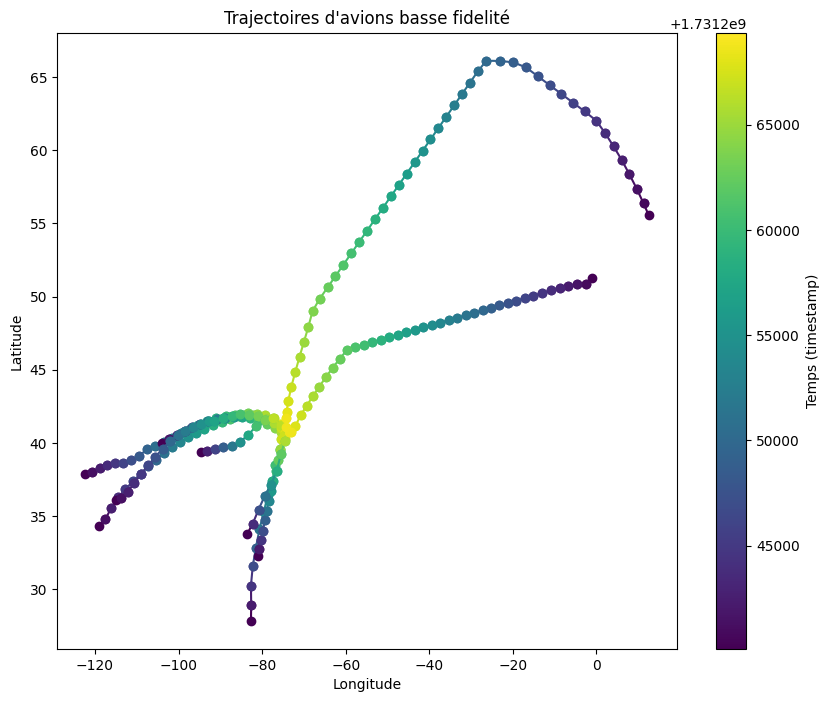

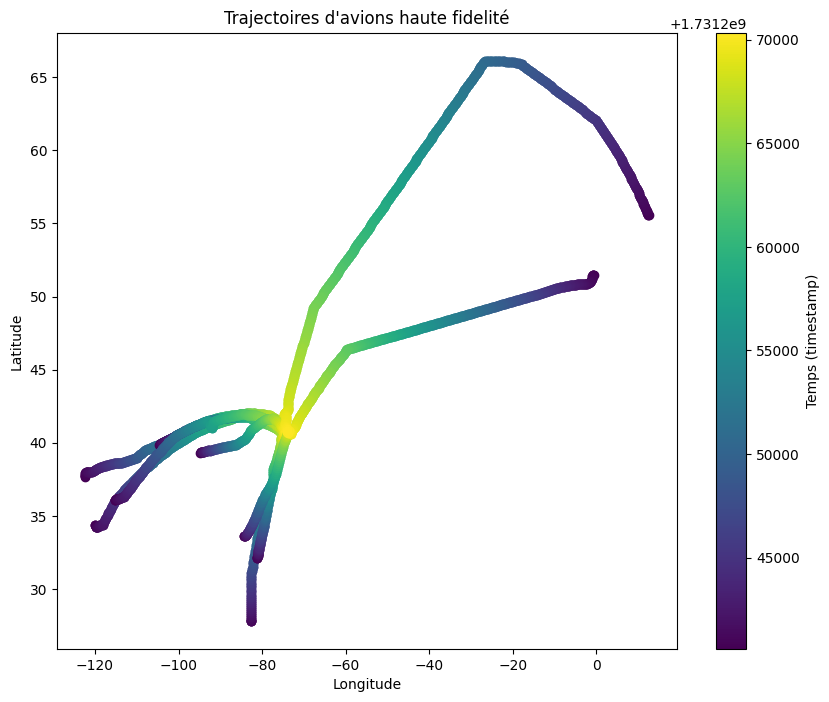

IndexError: tuple index out of range

<Figure size 1200x800 with 0 Axes>

In [72]:
# Identifiants de compte OpenSky Network
username = 'slimaboom51'
password = 'posgen-haczuP-0wojty'

# Coordonnée de Paris
"""latitude_min = 48.5  # Environ 30 km au sud de Paris
latitude_max = 49.0  # Environ 30 km au nord de Paris
longitude_min = 2.0  # Environ 30 km à l'ouest de Paris
longitude_max = 2.7  # Environ 30 km à l'est de Paris"""

# Coordonnée de New York
latitude_min = 40.5
latitude_max = 41.0
longitude_min = -74.5
longitude_max = -73.5

# Créer une instance de Simulation et récupérer les trajectoires
simulation = Simulation(username, password)
simulation.create_trajectoires(latitude_min, latitude_max, longitude_min, longitude_max)

# Charger un simulation
#path = 'ma_premiere_simulation.pkl'
#simulation = Simulation.charger_simulation(path)

# Créer des trajectoires basse et haute fidelité
simulation.generate_traj_bf()
simulation.generate_traj_hf()

# Affichage des trajectoires basse et haute fidelité
simulation.display_traj_basse_fidelite()
simulation.display_traj_haute_fidelite()

# Affichage des vitesse basse et haute fidelité
simulation.display_hf_velocity_profiles()
for trajectoire in simulation.traj_haute_fidelite:
    trajectoire.lisser_vitesses()
simulation.display_hf_velocity_profiles()

simulation.display_bf_velocity_profiles()

# Affichage des altitude basse et haute fidelité
simulation.display_hf_altitude_profiles()
simulation.display_bf_altitude_profiles()

# Sauvegarde des trajectoires brutes et extrapolées dans le même répertoire que le script
#simulation.sauvegarder_simulation("ma_troisieme_simulation.pkl")

# Detection de conflit
matrice = simulation.matrice_distances("traj_hf")
conflits = simulation.detecter_conflits(matrice, 10, 3000.0)

# Afficher les conflits détectés
for conflit in conflits:
    avion_i, avion_j, temps, dist_horizontale, dist_verticale = conflit
    print(f"Conflit détecté entre avion {avion_i} et avion {avion_j} à t={temps}:")
    print(f" - Distance horizontale: {dist_horizontale:.2f} NM")
    print(f" - Distance verticale: {dist_verticale:.2f} ft")




In [ ]:
# teste ajuster vitesse
trajectoire = Trajectoire(
    id_avion="TestPlane",
    positions=[(0.0, 0.0, 1000), (0.1, 0.1, 1000), (0.2, 0.2, 1000), (0.3, 0.3, 1000), (0.4, 0.4, 1000)],
    vitesses=[250, 250, 250, 250, 250],
    temps=[0, 10, 20, 30, 40]
)

# Essayer d'ajuster la vitesse au temps 10 avec une nouvelle vitesse de 300 m/s
print("Positions :", trajectoire.positions)
print("Vitesses :", trajectoire.vitesses)
# Limites : 10% de changement relatif et 50 m/s de changement absolu
trajectoire.ajuster_vitesse(t_changement=4, nouvelle_vitesse=370)

print("Positions ajustées :", trajectoire.positions)
print("Vitesses ajustées :", trajectoire.vitesses)


Positions : [(0.0, 0.0, 1000), (0.1, 0.1, 1000), (0.2, 0.2, 1000), (0.3, 0.3, 1000), (0.4, 0.4, 1000)]
Vitesses : [250, 250, 250, 250, 250]
Changement de vitesse rejeté : dv (120 m/s) dépasse la limite relative de 25.0 m/s.
Positions ajustées : [(0.0, 0.0, 1000), (0.1, 0.1, 1000), (0.2, 0.2, 1000), (0.3, 0.3, 1000), (0.4, 0.4, 1000)]
Vitesses ajustées : [250, 250, 250, 250, 250]
